# Prosup  Classifier

In [1]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from keras.models import load_model
from random import choice

## Data Analysis Section

<AxesSubplot:title={'center':'Subjects/Fazil/day_04_24_21/computed_Hammer02.csv'}>

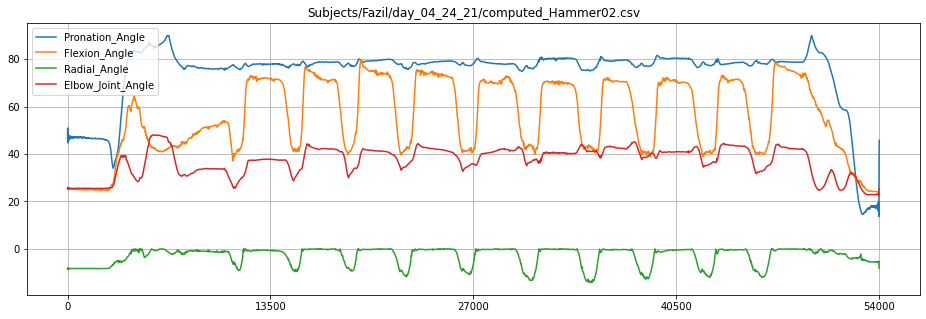

In [36]:
file = 'Subjects/Fazil/day_04_24_21/computed_Hammer02.csv'
angle_lables = ['Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle']
df = pd.read_csv(file,index_col=0)
df[angle_lables].plot(figsize=(16,5),title=file,grid=True,xticks=np.linspace(0,len(df),5))

In [32]:
df = df[13500:27000]

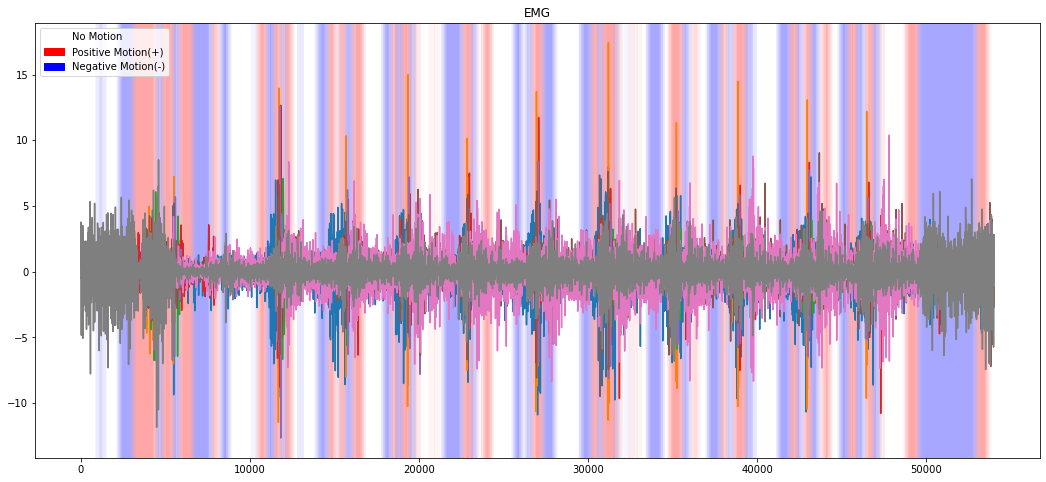

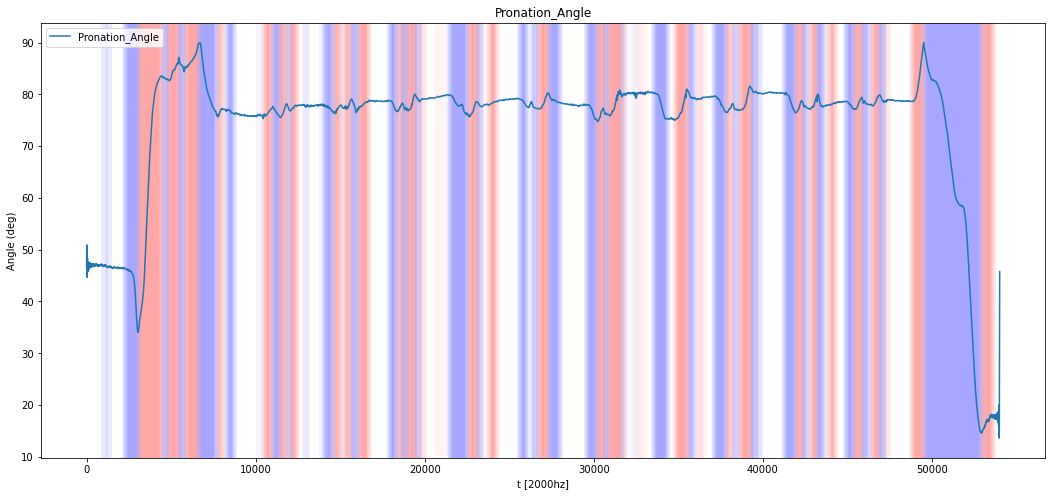

0 -> 40.8955223880597 %
1 -> 26.71641791044776 %
2 -> 32.38805970149254 %


(1340, 400, 8)

In [37]:
X, y = prep_data_prosup(df,400,interval=40,Normalize=False,plot=True,angle_thresh=0.0009,rms=False)
X.shape

## File Name Generation

In [6]:
files = []

In [7]:
path = 'Subjects/Fazil/day_04_24_21'
# trial_names = ['Hammer'] # 'Bulb','Hammer' ,'Cup','Screw'
trial_names = ['Bulb','Hammer' ,'Cup','Screw']
for exp in trial_names:
    for i in range(3):
        if(i==0):
            files.append(path+'/computed_'+exp+'.csv')
        else:
            files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

['Subjects/Fazil/day_04_24_21/computed_Bulb.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw02.csv']

In [8]:
path = 'Subjects/Fazil/day_04_14_21'
# trial_names = ['Hammer','Bulb'] # 'Bulb','Hammer' ,'Cup','Screw'
trial_names = ['Bulb','Hammer' ,'Cup']
for exp in trial_names:
    for i in range(3):
        if(i==0):
            files.append(path+'/computed_'+exp+'.csv')
        else:
            files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

['Subjects/Fazil/day_04_24_21/computed_Bulb.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw02.csv',
 'Subjects/Fazil/day_04_14_21/computed_Bulb.csv',
 'Subjects/Fazil/day_04_14_21/computed_Bulb01.csv',
 'Subjects/Fazil/day_04_14_21/computed_Bulb02.csv',
 'Subjects/Fazil/day_04_14_21/computed_Hammer.csv',
 'Subjects/Fazil/day_04_14_21/computed_Hammer01.csv',
 'Subjects/Fazil/day_04_14_21/computed_Hammer02.csv',
 'Subjects/Fazil/day_04_14_21/computed_Cup.csv',
 'Subjects/Fazi

In [9]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0))

## Data Augumentation

In [9]:
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG8','EMG7']

In [ ]:
files_df_aug = []

for df in tqdm(files_df):
    theta = choice(np.linspace(0,0.4,10))
    emg_array = np.array(add__Gausian_noise(df[emg_labels],theta))
    df[emg_labels] = emg_array
    files_df_aug.append(df)

In [ ]:
files_df = files_df+files_df_aug

## Data Prep Pipeline

### Parameters

In [10]:
window = 400
interval = 6
Normalize = False
rms = False
angle_thresh_prosup = 0.0009

In [11]:
X_prosup, y_prosup = multiple_prep_data_prosup(files_df,
                                               window,
                                               interval,
                                               Normalize,
                                               rms,
                                               angle_thresh_prosup)
print(X_prosup.shape,y_prosup.shape)


(231609, 400, 8) (231609, 3)


## Whole Normalize

In [12]:
X = X_prosup.reshape((X_prosup.shape[0]*X_prosup.shape[1],X_prosup.shape[2]))
X = norm(X)
# X = min_max(X)
X_prosup = X.reshape(X_prosup.shape)

In [13]:
np.save('prepared_data/X_prosup',X_prosup)
np.save('prepared_data/y_prosup',y_prosup)

In [2]:
X = np.load('prepared_data/X_prosup.npy')
y = np.load('prepared_data/y_prosup.npy')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_prosup, y_prosup,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(185287, 400, 8)
(46322, 400, 8)
(185287, 3)
(46322, 3)


In [15]:
y_true = []
for d in y_test:
    idx = list(d).index(1)
    y_true.append(idx)

In [16]:
def count(y):
    s0 = 0
    s1 = 0
    s2 = 0
    for arr in y:
        if arr[0]==1:
            s0 = s0+1
        if arr[1]==1:
            s1 = s1+1
        if arr[2]==1:
            s2 = s2+1
    ls = [s0,s1,s2]
    for i in range(3):
        print(i,'-',ls[i],'[',ls[i]*100/len(y),'%]')

In [17]:
print(count(y_train))
print(count(y_test))

0 - 61826 [ 33.36769444159601 %]
1 - 63100 [ 34.05527640903031 %]
2 - 60361 [ 32.57702914937367 %]
None
0 - 15540 [ 33.54777427572212 %]
1 - 15579 [ 33.631967531626444 %]
2 - 15203 [ 32.82025819265144 %]
None


# InceptionTime Trainer

In [18]:
import numpy as np
import sklearn
import pandas as pd
import sys
import subprocess
import tensorflow as tf
from InceptionTime.classifiers.inception import Classifier_INCEPTION

## Build Model

In [19]:
clf = Classifier_INCEPTION('', (X_train.shape[1],X_train.shape[2]),nb_classes=3,
                            verbose=True,batch_size=128,nb_epochs=25,nb_filters=16,
                            depth=12, kernel_size=11)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 8)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 400, 32)      256         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 400, 8)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 400, 16)      5120        conv1d[0][0]                     
______________________________________________________________________________________________

In [ ]:
df_metrics = clf.fit(X_train, y_train, X_test, y_test, y_true,plot_test_acc=True)

Epoch 1/25
 743/1448 [==============>...............] - ETA: 1:09 - loss: 0.9944 - accuracy: 0.5038

In [27]:
clf.model = load_model('last_model.hdf5')

In [ ]:
best_model = load_model('best_model.hdf5')
best_model.save('models/DTM_{}.hdf5'.format(window))

## Testing

In [ ]:
model = load_model('models/Prosup_{}.hdf5'.format(window))

In [ ]:
mx_scaler = load(open('min_max.pkl', 'rb'))
std_scaler = load(open('standard_scaler.pkl', 'rb'))

In [ ]:
model.evaluate(X_dtm, y_dtm)

## Plot Results

In [18]:
%matplotlib inline
metrics_df = pd.read_csv('df_metrics.csv')
best_model_df = pd.read_csv('df_best_model.csv')
history_df = pd.read_csv('history.csv')

In [19]:
metrics_df

,precision,accuracy,recall,duration
0,0.908488,0.932602,0.935385,4384.434993


<AxesSubplot:title={'center':'Loss'}>

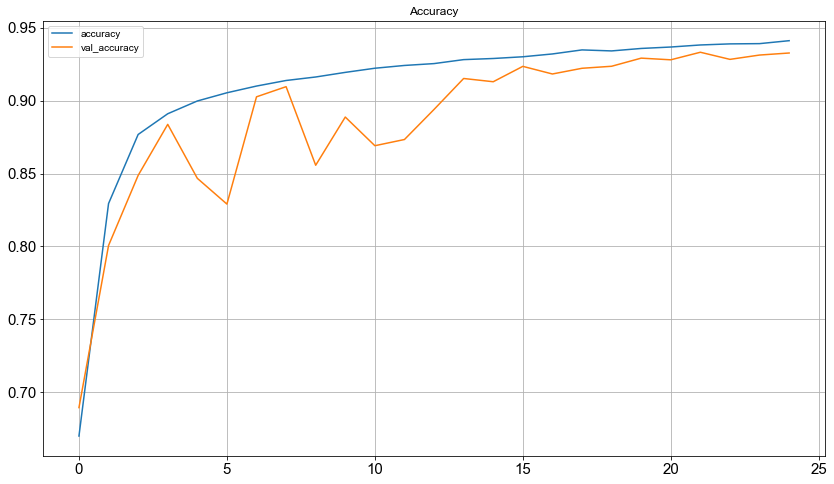

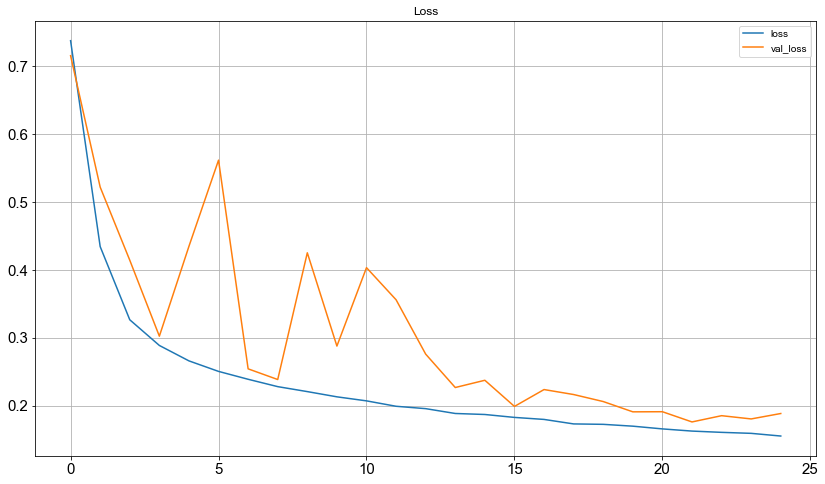

In [20]:
history_df[['accuracy','val_accuracy']].plot(figsize=(14,8),title='Accuracy',grid=True,fontsize=15)
history_df[['loss','val_loss']].plot(figsize=(14,8),title='Loss',grid=True,fontsize=15)